In [1]:
module My

using ConcreteStructs: @concrete
using ForwardDiff: derivative
using Parameters: @unpack
using Random: default_rng

@concrete struct LFProblem ϕ; H; F; dt; nsteps end

"""ϕ should be a potential function."""
function LFProblem(ϕ; dt = 0.05, nsteps = 100)
    H(x, v) = v^2/2 + ϕ(x)
    F(x) = -derivative(ϕ, x)
    LFProblem(ϕ, H, F, dt, nsteps)
end

function update(lf::LFProblem, x, v)
    @unpack dt, F = lf
    vtmp = v + F(x)*dt/2
    xnew = x + vtmp*dt
    vnew = vtmp + F(xnew)*dt/2
    xnew, vnew
end

"""Numerically solve Hamilton's equation of motion with leapfrog method"""
function solve(lf::LFProblem, x, v)
    @unpack nsteps = lf
    for _ in 1:nsteps
        x, v = update(lf, x, v)
    end
    x, v
end

"""Hamiltonian Monte Carlo"""
function HMC(lf::LFProblem; x0 = randn(), niters = 10^5, burnin = 0, rng = default_rng())
    @unpack H = lf
    T = typeof(x0)
    x = x0
    for _ in 1:burnin
        v = randn(rng, T)
        x, v = solve(lf, x, v)
    end
    X = Vector{T}(undef, niters)
    for i in 1:niters
        v = randn(rng, T)
        xnew, vnew = solve(lf, x, v)
        dH = H(xnew, vnew) - H(x, v)
        alpha = min(1, exp(-dH))
        rand(rng) ≤ alpha && (x = xnew)
        X[i] = x
    end
    X
end

end

Main.My

In [2]:
using Plots
using QuadGK
using BenchmarkTools

  0.232096 seconds (482.30 k allocations: 30.513 MiB, 63.68% compilation time)


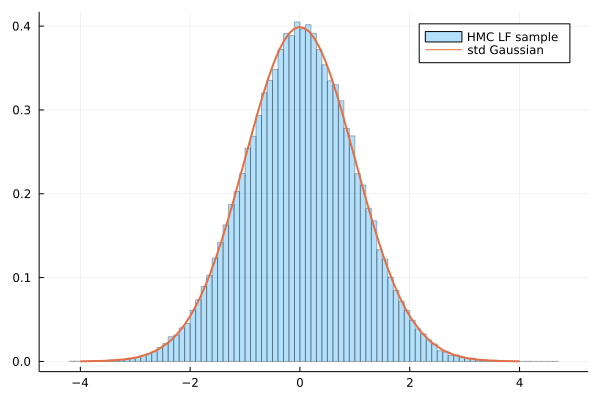

In [3]:
ϕ(x) = x^2/2
lf = My.LFProblem(ϕ)
@time X = My.HMC(lf)
histogram(X; norm=true, alpha=0.3, label="HMC LF sample")
plot!(x -> exp(-x^2/2)/√(2π), -4, 4, label="std Gaussian", lw=2)

In [4]:
@btime My.HMC($lf);

  79.794 ms (2 allocations: 781.33 KiB)


  0.238284 seconds (403.70 k allocations: 25.485 MiB, 3.53% gc time, 54.26% compilation time)


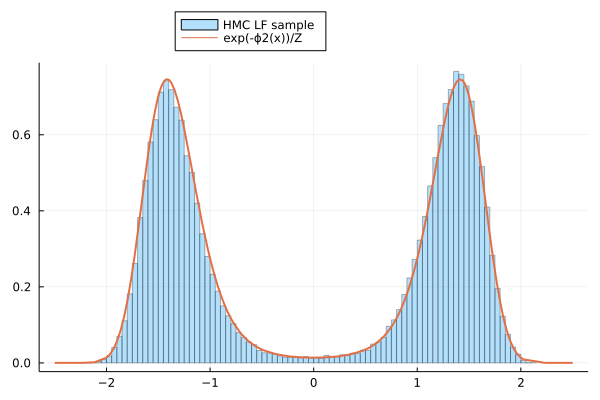

In [5]:
ϕ2(x) = x^4 - 4x^2
Z = quadgk(x -> exp(-ϕ2(x)), -Inf, Inf)[1]
lf2 = My.LFProblem(ϕ2)
@time X2 = My.HMC(lf2)
histogram(X2; norm=true, alpha=0.3, label="HMC LF sample", bin=100)
plot!(x -> exp(-ϕ2(x))/Z, -2.5, 2.5; label="exp(-ϕ2(x))/Z", lw=2)
plot!(; legend=:outertop)

In [6]:
@btime My.HMC($lf2);

  105.846 ms (2 allocations: 781.33 KiB)


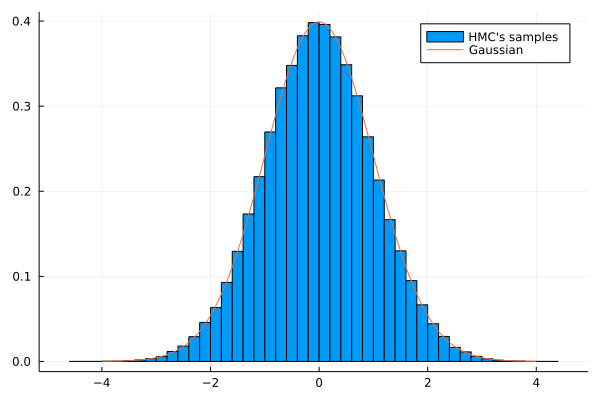

  1.585269 seconds (55.40 M allocations: 1.048 GiB, 5.53% gc time, 9.03% compilation time)


In [7]:
# https://github.com/moruten/julia-code/blob/c0dfc2443d6b74256364e698b3edb37f98214ce7/Test-2021-9-3-no4.ipynb

#HMC method
using Plots
using StatsBase
using Random
using Printf
using Distributions
using BenchmarkTools
using QuadGK
using SpecialFunctions
using Zygote

# Generating Gaussian distribution (1-dim) by using HMC method

# # of configurations
n_config = 1_00_000

# size of a configuration
n_size = 1

# # of step of Leapfrog method
n_tau = 100

# time period of Hamilton equation
τ = 5.0

function S(x)
    sum(0.5*x[i]^2 for i=1:n_size)
end

function dSdx(x,k)
    return x
end

function H(x,p)
    K = sum(p[i]^2 for i=1:n_size)
    return S(x) + 0.5*K
end

#１変数更新のHMC法
function HMC_1dim(x)
        #初期化
        p_ini = rand(Normal(0,1),n_size)
        p_fin = zeros(n_size)
        x_ini = zeros(n_size)
        x_fin = zeros(n_size)
    
        #初期配位を保存
        for i=1:n_size x_ini[i] = x[i] end
    
        #初期配位のハミルトニアンを計算
        H_ini = H(x_ini,p_ini)
    
        #リープフロッグで時間発展
        leapfrog!(x,p_ini)
    
        #時間発展後の配位を保存
        for i=1:n_size x_fin[i] = x[i]; p_fin[i] = p_ini[i] end
    
        #時間発展後のハミルトニアンを計算
        H_fin = H(x_fin,p_fin)
    
        #Metropolis check
        r=rand()
        if r<exp(H_ini - H_fin)
            for i=1:n_size x[i] = x_fin[i] end
        else
            for i=1:n_size x[i] = x_ini[i] end
        end
end

#x,pをリープフロッグ法で更新する．
function leapfrog!(x,p)
    Δτ  = τ/n_tau 
    p0  = 0.0
    p1  = 0.0
    x05 = 0.0
    x15 = 0.0
    for k=1:n_size
        #initial setting : τ0
        p0  = p[k]
        x05 = x[k] + p0 * 0.5*Δτ
    
        #(n-1)step : τ0 -> τn-1 
        for i=1:n_tau-1
            p1  = p0 - dSdx(x05,k)*Δτ
            x15 = x05 + p1*Δτ
        
            p0  = p1
            x05 = x15
        end
    
        #final step : τn-1 -> τn
        p_end = p1 - dSdx(x15,k)*Δτ
        x_end = x15 + p_end*0.5*Δτ
        
        x[k]  = x_end
        p[k]  = p_end
    end
end

""" main """
#set of configurations
Ω = zeros(n_config)

#configuration
x = zeros(n_size)

@time for j=1:n_config
    HMC_1dim(x)
    Ω[j] = x[1]
end

Ω

gauss(x) = exp(-0.5*x^2)/sqrt(2*pi)
xr = range(-4,4,length=10001)

plot(Ω,st=:histogram,nbins=50,norm=:pdf,label="HMC's samples")
plot!(xr,gauss.(xr),label="Gaussian") |> display

In [8]:
function HMC_orig!()
    for j=1:n_config
        HMC_1dim(x)
        Ω[j] = x[1]
    end
end

""" main """
#set of configurations
Ω = zeros(n_config)

#configuration
x = zeros(n_size)

@btime HMC_orig!()

  1.356 s (54998979 allocations: 1.02 GiB)


In [9]:
length(Ω), length(X)

(100000, 100000)

In [10]:
1.3/0.080

16.25